# Exercise 8
##  Basics Sensor Fusion Course, 2020 Autumn
## Muhammad F. Emzir

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as sla
#sns.set('talk')
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
fig_size = (10,10)

## Question 1

### Spring model discretization

In [2]:
k_spring = 50.
eta_spring = 0.1
m_block = 1.
A_spring = np.array([[0., 1.],[-k_spring/m_block, -eta_spring/m_block]])

Since the solution is given by
$$
\dot{x}_t = \exp(At)x_0
$$
Assuming that `scipy.linalg.expm` is exact then we can have

In [3]:
t = np.linspace(0.,1.,101,endpoint=True)
x = np.zeros((t.shape[0],2))
x[0] = np.array([1.,1.])

In [4]:
for i in range(t.shape[0]-1):
    x[i+1] = sla.expm(A_spring*t[i+1])@x[0]

Discretized version

In [5]:
dt = t[1]-t[0]
A_discrt = sla.expm(A_spring*dt)

In [6]:
x_discretized = np.zeros_like(x)

In [7]:
x_discretized[0] = x[0]
for i in range(t.shape[0]-1):
    x_discretized[i+1] = A_discrt@x_discretized[i]

Text(0, 0.5, '$x_1$')

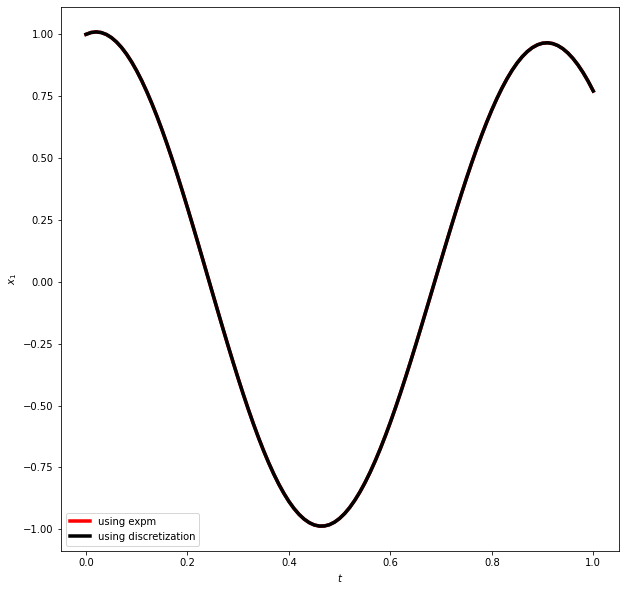

In [11]:
plt.figure(figsize=(10,10))
plt.plot(t,x[:,0],'-r',label='using expm', linewidth=3.5)
plt.plot(t,x_discretized[:,0],'-k',label='using discretization', linewidth=3.5)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x_1$')

Text(0, 0.5, '$x_2$')

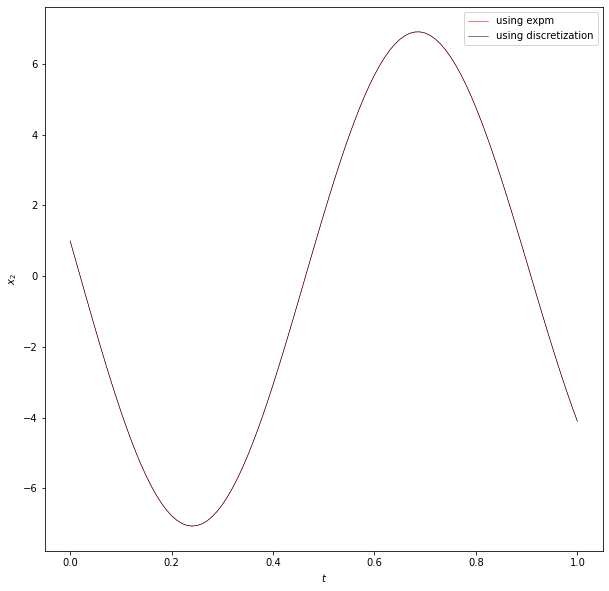

In [12]:
plt.figure(figsize=(10,10))
plt.plot(t,x[:,1],'-r',label='using expm', linewidth=0.5)
plt.plot(t,x_discretized[:,1],'-k',label='using discretization', linewidth=0.5)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x_2$')

## Question 2
### Wiener velocity model

In [13]:
A_wiener = np.array([[0., 1.],[0., 0.]])
B_wiener = np.array([[0.],[1.]])
variance = 0.1
dt = 0.1

From our analytical computation, we have

In [14]:
F_wiener = np.array([[1., dt],[0., 1.]])
Q_wiener_discrete = variance * np.array([[(dt**3)/3, (dt**2)/2],[(dt**2)/2,dt]])
x_wiener_init = np.array([0.,1.])

In [15]:
t_wiener = np.arange(1001)*dt
#q = np.random.multivariate_normal(np.zeros(2),Q_wiener_discrete,(t_wiener.shape[0]))
q = np.random.randn(t_wiener.shape[0],2)@np.linalg.cholesky(Q_wiener_discrete)

Single trajectory

In [16]:
def propagate_linear_discrete_system(F,x_init,length):
    x = np.zeros((length,x_init.shape[0]))
    x[0] = x_init
    for i in range(length-1):
        x[i+1] = F@x[i]
    
    return x

def propagate_linear_discrete_system_mean_and_covariance(F,x_init,cov_init,Q_discrete,length):
    x = np.zeros((length,x_init.shape[0]))
    P = np.zeros((length,x_init.shape[0],x_init.shape[0]))
    x[0] = x_init
    P[0] = cov_init
    for i in range(length-1):
        x[i+1] = F@x[i]
        P[i+1] = F@P[i]@F.T + Q_discrete
    
    return x, P

def propagate_linear_discrete_system_with_noise(F,x_init,length, q):
    x = np.zeros((length,x_init.shape[0]))
    x[0] = x_init
    for i in range(length-1):
        x[i+1] = F@x[i]+q[i]
    
    return x

In [17]:
x_wiener = propagate_linear_discrete_system_with_noise(F_wiener,x_wiener_init,t.shape[0],q)

Text(0, 0.5, '$x_1$')

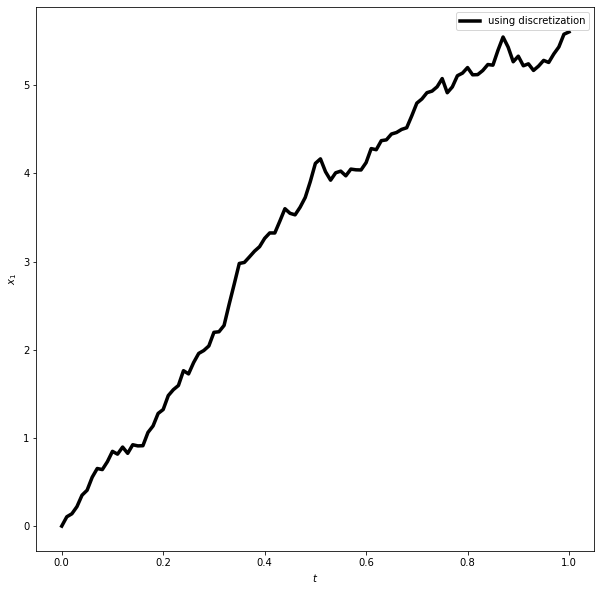

In [18]:
plt.figure(figsize=fig_size)
plt.plot(t,x_wiener[:,0],'-k',label='using discretization', linewidth=3.5)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x_1$')

Text(0, 0.5, '$x_2$')

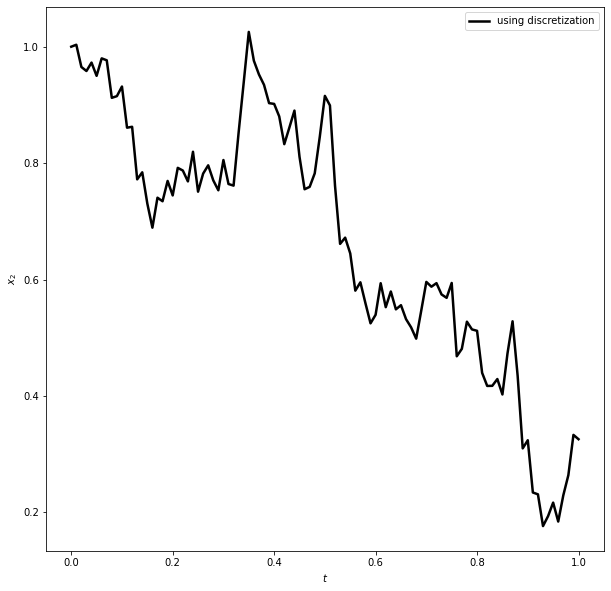

In [19]:
plt.figure(figsize=fig_size)
plt.plot(t,x_wiener[:,1],'-k',label='using discretization', linewidth=2.5)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x_2$')

In [20]:
sample_num = 1000
x_wiener_many = np.zeros((sample_num,t.shape[0],2))
q_many = np.random.multivariate_normal(np.zeros(2),Q_wiener_discrete,(sample_num,t_wiener.shape[0]))

In [21]:
np.cov(q_many[:,10,:].T)

array([[3.41583725e-05, 5.21505504e-04],
       [5.21505504e-04, 1.04743598e-02]])

In [22]:
Q_wiener_discrete

array([[3.33333333e-05, 5.00000000e-04],
       [5.00000000e-04, 1.00000000e-02]])

In [23]:
for i in range(sample_num):
    x_wiener_many[i] = propagate_linear_discrete_system_with_noise(F_wiener,x_wiener_init,t.shape[0],q_many[i])

In [24]:
P_init = 0*np.eye(2)
x_wiener_mean, P_wiener_mean = propagate_linear_discrete_system_mean_and_covariance(F_wiener,x_wiener_init,P_init,Q_wiener_discrete,t.shape[0])

In [25]:
x_wiener_empiric_mean = np.mean(x_wiener_many,axis=0)
delta_x = x_wiener_many - x_wiener_empiric_mean

#Prehistoric procedure to calculate empiric wiener covariance. :D
temp = np.zeros((sample_num,t.shape[0],2,2))
for i in range(sample_num):
    for j in range(t.shape[0]):
        temp[i,j,:,:] = np.outer(delta_x[i,j],delta_x[i,j])
cov_wiener_empiric = np.mean(temp,axis=0)

Text(0, 0.5, '$x_1$')

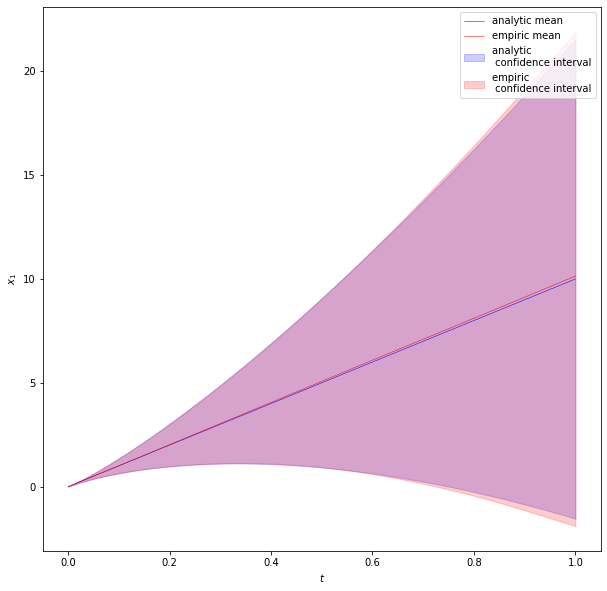

In [26]:
plt.figure(figsize=fig_size)
plt.plot(t,x_wiener_mean[:,0],'-b',label='analytic mean', linewidth=0.5)
plt.fill_between(t,x_wiener_mean[:,0]+2*np.sqrt(P_wiener_mean[:,0,0]),x_wiener_mean[:,0]-2*np.sqrt(P_wiener_mean[:,0,0]),color='blue',alpha=0.2,label='analytic \n confidence interval')
plt.plot(t,x_wiener_empiric_mean[:,0],'-r',label='empiric mean', linewidth=0.5)
plt.fill_between(t,x_wiener_mean[:,0]+2*np.sqrt(cov_wiener_empiric[:,0,0]),x_wiener_mean[:,0]-2*np.sqrt(cov_wiener_empiric[:,0,0]),color='red',alpha=0.2,label='empiric \n confidence interval')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x_1$')

Text(0, 0.5, '$x_2$')

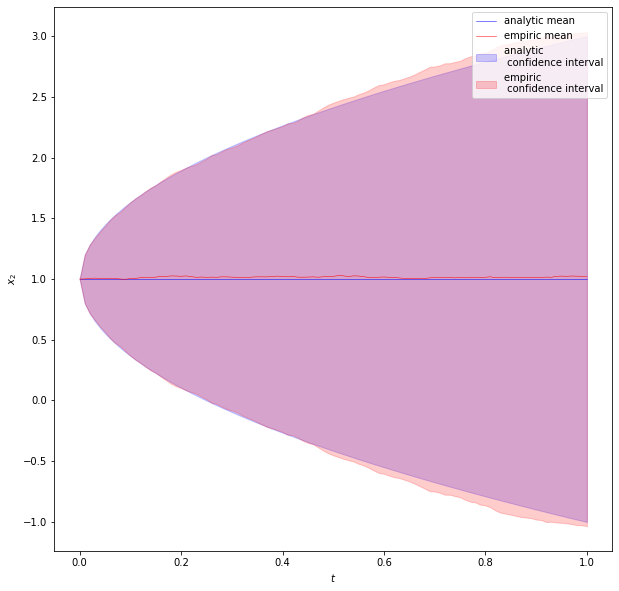

In [27]:
plt.figure(figsize=fig_size)
plt.plot(t,x_wiener_mean[:,1],'-b',label='analytic mean', linewidth=0.5)
plt.fill_between(t,x_wiener_mean[:,1]+2*np.sqrt(P_wiener_mean[:,1,1]),x_wiener_mean[:,1]-2*np.sqrt(P_wiener_mean[:,1,1]),color='blue',alpha=0.2,label='analytic \n confidence interval')
plt.plot(t,x_wiener_empiric_mean[:,1],'-r',label='empiric mean', linewidth=0.5)
plt.fill_between(t,x_wiener_mean[:,1]+2*np.sqrt(cov_wiener_empiric[:,1,1]),x_wiener_mean[:,1]-2*np.sqrt(cov_wiener_empiric[:,1,1]),color='red',alpha=0.2,label='empiric \n confidence interval')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$x_2$')

## Question 3

### We will use parts from Ex 7:

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def robot_dynamic(t,x,u):
    return np.array([u[0]*np.cos(x[2]), u[0]*np.sin(x[2]), u[1]])

def robot_jacobian(t,x,u):
    jac = np.zeros((x.shape[0],x.shape[0]))
    jac[0,2] = -u[0]*np.sin(x[2])
    jac[1,2] = u[0]*np.cos(x[2])
    return jac
    
robot_init = np.array([0.,0.,0.])
t_robot = np.linspace(0.,5.,501)
dt_robot = t_robot[1]-t_robot[0]
u_robot = np.zeros((t_robot.shape[0],2))

for i in range(t_robot.shape[0]):
    if 0<= t_robot[i] < 1:
        u_robot[i,0] = t_robot[i]
    elif 1<= t_robot[i] < 4:
        u_robot[i,0] = 1
    else:
        u_robot[i,0] = 5-t_robot[i]
        
    if 0<= t_robot[i] < 2:
        u_robot[i,1] = 0
    elif 2<= t_robot[i] < 3:
        u_robot[i,1] = np.pi
    else:
        u_robot[i,1] = 0

In [3]:
def euler(f,t_now, x_now,u_now, dt):
    return x_now + f(t_now, x_now,u_now)*dt

def euler_propagate(f,t, x_init,u,dt):
    x_res = np.zeros((t.shape[0],x_init.shape[0]))
    x_res[0] = x_init
    for i in range(x_res.shape[0]-1):
        x_res[i+1] = euler(f,t[i], x_res[i],u[i],dt)
    return x_res

def euler_stochatic_propagate(f,t, x_init,u, w, dt):
    x_res = np.zeros((u.shape[0],x_init.shape[0]))
    x_res[0] = x_init
    for i in range(x_res.shape[0]-1):
        x_res[i+1] = euler(f,t[i], x_res[i],u[i],dt) +  w[i]
    return x_res

def linearization_propagate(f,jac, t, x_init, u, w, dt):
    x_res = np.zeros((t.shape[0],x_init.shape[0]))
    I = np.eye(x_init.shape[0])
    x_res[0] = x_init
    for i in range(x_res.shape[0]-1):
        A = jac(t[i],x_res[i],u[i])
        F = (I + 0.5*A*dt + A@A*dt*dt/6)*dt #this is approximation
        x_res[i+1] = x_res[i] + F@f(t[i],x_res[i],u[i]) + F@w[i]
    return x_res

def rk4(f,t_now, x_now,u_now, dt):
    k1 = f(t_now, x_now,u_now)
    k2 = f(t_now+0.5*dt,x_now+0.5*dt*k1,u_now)
    k3 = f(t_now+0.5*dt, x_now+0.5*dt*k2,u_now)
    k4 = f(t_now+dt, x_now+dt*k3,u_now)
    return x_now+dt*(k1+2*k2+2*k3+k4)/6


def rk4_propagate(f,t, x_init,u,dt):
    x_res = np.zeros((u.shape[0],x_init.shape[0]))
    x_res[0] = x_init
    for i in range(x_res.shape[0]-1):
        x_res[i+1] = rk4(f,t[i], x_res[i],u[i],dt)
    return x_res

In [4]:
Q_robot = np.diag([1e-2,1e-2,1e-2])
Q_robot_discrete = dt_robot*Q_robot
q_robot = np.random.randn(t_robot.shape[0],3)@np.linalg.cholesky(Q_robot)
q_robot_discrete = np.sqrt(dt_robot)*np.random.randn(t_robot.shape[0],3)@np.linalg.cholesky(Q_robot_discrete)

In [5]:
x_euler_maruyama = euler_stochatic_propagate(robot_dynamic,t_robot, robot_init, u_robot, q_robot_discrete, dt_robot)
x_robot_RK = rk4_propagate(robot_dynamic, t_robot, robot_init, u_robot, dt_robot)

In [6]:
x_linear = linearization_propagate(robot_dynamic,robot_jacobian, t_robot, robot_init, u_robot, q_robot, dt_robot)

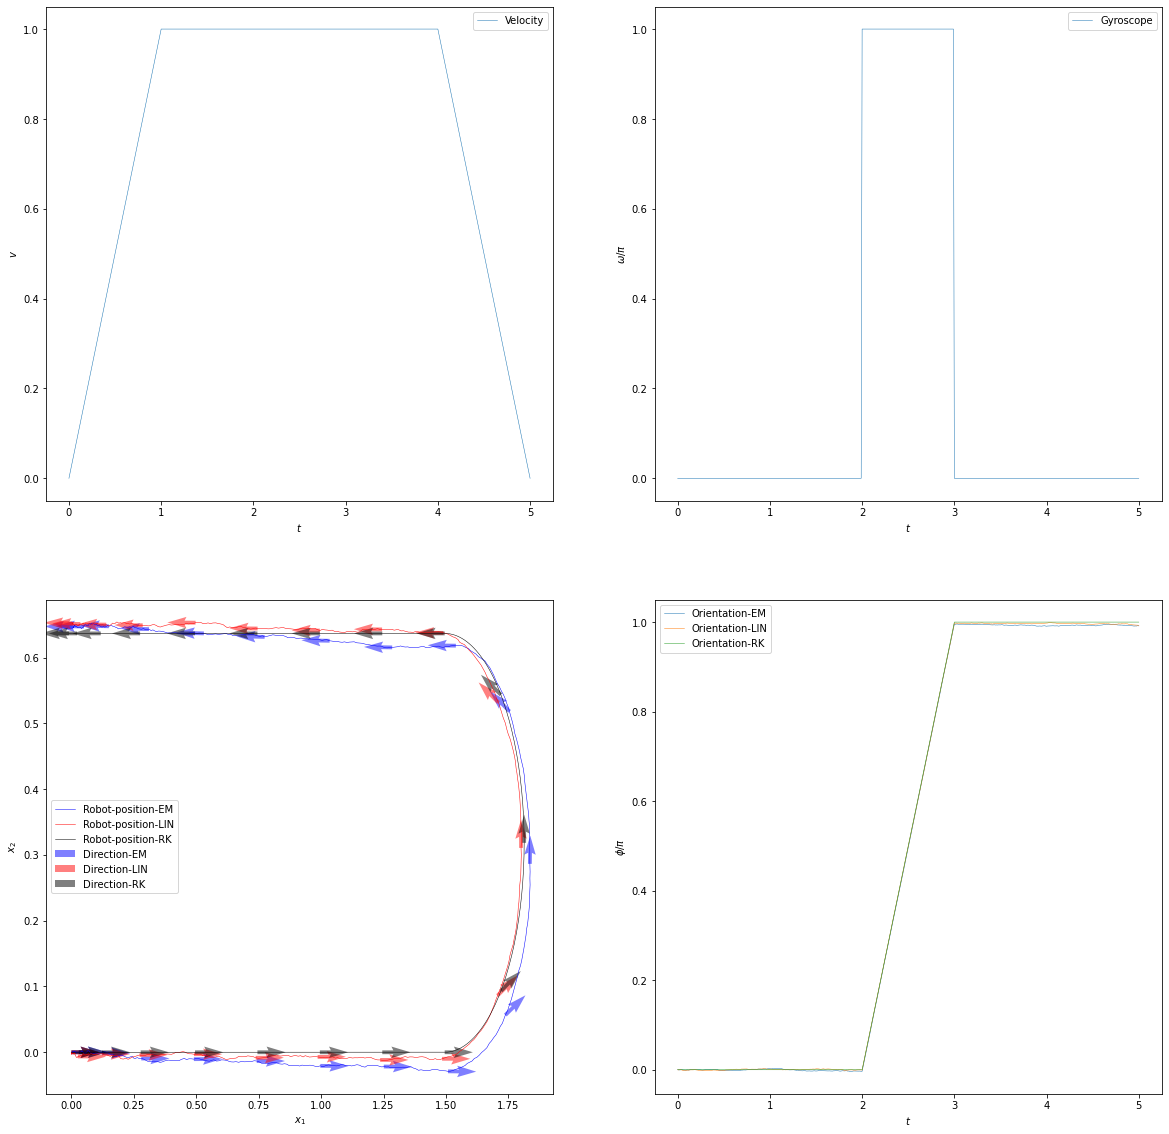

In [7]:
f, ax = plt.subplots(2,2, figsize=(20,20))
skip = 25
ax[0,0].plot(t_robot,u_robot[:,0], label='Velocity', linewidth=0.5)
ax[0,0].set_xlabel('$t$')
ax[0,0].set_ylabel('$v$')
ax[0,0].legend()

ax[0,1].plot(t_robot,u_robot[:,1]/np.pi, label='Gyroscope', linewidth=0.5)
ax[0,1].set_xlabel('$t$')
ax[0,1].set_ylabel('$\omega / \pi$')
ax[0,1].legend()
ax[1,0].plot(x_euler_maruyama[:,0],x_euler_maruyama[:,1], '-b', label='Robot-position-EM', linewidth=0.5)
ax[1,0].plot(x_linear[:,0],x_linear[:,1], '-r', label='Robot-position-LIN', linewidth=0.5)
ax[1,0].plot(x_robot_RK[:,0],x_robot_RK[:,1], '-k', label='Robot-position-RK', linewidth=0.5)
ax[1,0].quiver(x_euler_maruyama[::skip,0],x_euler_maruyama[::skip,1],
               np.cos(x_euler_maruyama[::skip,2]),np.sin(x_euler_maruyama[::skip,2]),
               label='Direction-EM', linewidth=0.5, alpha=0.5, color='blue')
ax[1,0].quiver(x_linear[::skip,0],x_linear[::skip,1],
               np.cos(x_linear[::skip,2]),np.sin(x_linear[::skip,2]),
               label='Direction-LIN', linewidth=0.5, alpha=0.5, color='red')
ax[1,0].quiver(x_robot_RK[::skip,0],x_robot_RK[::skip,1],
               np.cos(x_robot_RK[::skip,2]),np.sin(x_robot_RK[::skip,2]),
               label='Direction-RK', linewidth=0.5, alpha=0.5, color='black')

ax[1,0].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')
ax[1,0].legend()
ax[1,1].plot(t_robot,x_euler_maruyama[:,2]/np.pi, label='Orientation-EM', linewidth=0.5)
ax[1,1].plot(t_robot,x_linear[:,2]/np.pi, label='Orientation-LIN', linewidth=0.5)
ax[1,1].plot(t_robot,x_robot_RK[:,2]/np.pi, label='Orientation-RK', linewidth=0.5)
ax[1,1].set_xlabel('$t$')
ax[1,1].set_ylabel('$\phi / \pi$')
ax[1,1].legend()